In [8]:
# train_yolo_coco128.py
# Transfer learning rápido com YOLOv8 no dataset rotulado COCO128 (pequenininho).
# Requisitos: Python 3.8+, GPU opcional. Execute: python train_yolo_coco128.py

import os
import subprocess
import sys

def ensure_ultralytics():
    try:
        import ultralytics  # noqa: F401
    except ImportError:
        print("Instalando 'ultralytics'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "ultralytics"])
    finally:
        from ultralytics import YOLO
        return YOLO

def main():
    YOLO = ensure_ultralytics()
    import torch

    # Escolhe peso pré-treinado leve (nano) para treino rápido
    pretrained_weights = "yolov8n.pt"  # você pode trocar por 'yolov8s.pt' se quiser um pouco melhor

    # Cria/seleciona diretório de trabalho
    os.makedirs("runs", exist_ok=True)

    # Mostra info de dispositivo
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"➡️  Treinando em: {device}")

    # Carrega modelo com pesos pré-treinados (transfer learning)
    model = YOLO(pretrained_weights)

    # O Ultralytics baixa o COCO128 automaticamente ao apontar para 'coco128.yaml'
    # Ajustes para treino rápido em dataset pequeno:
    # - epochs: 5–20 são suficientes para demonstrar; aumente se quiser
    # - imgsz: 640 é padrão; 416 pode acelerar ainda mais
    # - batch: "auto" deixa o pacote decidir
    # - lr0/lrf: um setup conservador para não "esquecer" o conhecimento prévio
    results = model.train(
        data="coco128.yaml",
        epochs=10,
        imgsz=640,
        batch=1,
        device=0 if device == "cuda" else "cpu",
        lr0=0.001,   # taxa inicial de aprendizado (um pouco mais baixa ajuda em datasets pequenos)
        lrf=0.01,    # fator de decaimento do LR
        patience=20, # early stopping
        weight_decay=0.0005,
        mosaic=0.7,  # leve aumento de dados
        hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
        project="runs",
        name="train_coco128_yolov8n"
    )

    # Validação no conjunto de validação do dataset
    print("➡️  Validando modelo no conjunto de validação...")
    metrics = model.val(data="coco128.yaml", imgsz=640, device=0 if device == "cuda" else "cpu")
    print("Métricas principais:", {k: metrics.results_dict[k] for k in ['metrics/mAP50', 'metrics/mAP50-95'] if k in metrics.results_dict})

    # Inferência de exemplo: roda em 4 imagens de validação
    # O Ultralytics já tem um caminho default para as imagens do COCO128 após o download
    example_images = [
        "datasets/coco128/images/train/000000000034.jpg",
        "datasets/coco128/images/train/000000000036.jpg",
        "datasets/coco128/images/train/000000000042.jpg",
        "datasets/coco128/images/train/000000000054.jpg",
    ]
    example_images = [p for p in example_images if os.path.exists(p)]
    if not example_images:
        # fallback: usa um diretório se os nomes exatos mudarem
        fallback_dir = "datasets/coco128/images/train"
        if os.path.isdir(fallback_dir):
            # pega até 4 imagens quaisquer
            example_images = [os.path.join(fallback_dir, f) for f in os.listdir(fallback_dir) if f.lower().endswith((".jpg", ".png"))][:4]

    print("➡️  Rodando inferência de exemplo…")
    preds = model.predict(
        source=example_images if example_images else "datasets/coco128/images/train",
        save=True,
        conf=0.25,
        imgsz=640,
        device=0 if device == "cuda" else "cpu",
        project="runs",
        name="predict_coco128_yolov8n",
        max_det=300
    )
    print("✅  Pronto! Verifique as imagens anotadas em:", preds[0].save_dir if preds else "runs/detect/predict_coco128_yolov8n")

if __name__ == "__main__":
    main()


➡️  Treinando em: cpu
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.7, multi_scale=False, name=train_coco128_yolov8n4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pos

train: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1119.5±452.5 MB/s, size: 52.5 KB)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

Plotting labels to runs/train_coco128_yolov8n4/labels.jpg... 



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/train_coco128_yolov8n4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      1.398      3.933      1.409         16        640:  13%|█▎        | 17/128 [00:18<01:59,  1.08s/it]


KeyboardInterrupt: 

In [9]:
def main():
    YOLO = ensure_ultralytics()
    import torch
    from ultralytics.utils.downloads import download

    # Baixa o dataset COCO128 na pasta datasets/
    download("https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip", dir="datasets")

    pretrained_weights = "yolov8n.pt"
    os.makedirs("runs", exist_ok=True)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"➡️  Treinando em: {device}")

    model = YOLO(pretrained_weights)

    results = model.train(
        data="coco128.yaml",
        epochs=10,
        imgsz=640,
        batch=-1,  # auto batch
        device=0 if device == "cuda" else "cpu",
        lr0=0.001,
        lrf=0.01,
        patience=20,
        weight_decay=0.0005,
        mosaic=0.7,
        hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
        project="runs",
        name="train_coco128_yolov8n"
    )

    print("➡️  Validando modelo no conjunto de validação...")
    metrics = model.val(data="coco128.yaml", imgsz=640, device=0 if device == "cuda" else "cpu")
    print("Métricas principais:", {k: metrics.results_dict[k] for k in ['metrics/mAP50', 'metrics/mAP50-95'] if k in metrics.results_dict})


In [10]:
import requests
import os
from ultralytics import YOLO
from PIL import Image

# 1. Baixa uma imagem de exemplo (aqui vou pegar uma do COCO)
url = "https://ultralytics.com/images/bus.jpg"
img_path = "bus.jpg"

if not os.path.exists(img_path):
    print("➡️ Baixando imagem de teste...")
    r = requests.get(url, stream=True)
    with open(img_path, "wb") as f:
        f.write(r.content)

# 2. Carrega modelo YOLO (pré-treinado ou o seu fine-tuned)
# Se você já treinou antes, troque 'yolov8n.pt' pelo caminho dos seus pesos:
# ex: 'runs/train/train_coco128_yolov8n/weights/best.pt'
model = YOLO("yolov8n.pt")

# 3. Faz a predição
results = model.predict(source=img_path, save=True, conf=0.25)

# 4. Mostra resultado
print("✅ Detecção concluída!")
print("Classes detectadas:", results[0].boxes.cls.tolist())
print("Imagem anotada salva em:", results[0].save_dir)

# Opcional: abrir direto no Python
Image.open(os.path.join(results[0].save_dir, os.path.basename(img_path))).show()


➡️ Baixando imagem de teste...

image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 211.5ms
Speed: 6.8ms preprocess, 211.5ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
✅ Detecção concluída!
Classes detectadas: [5.0, 0.0, 0.0, 0.0, 0.0, 11.0]
Imagem anotada salva em: runs/detect/predict



image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 187.2ms
Speed: 4.6ms preprocess, 187.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict2
✅ Imagem anotada salva em: runs/detect/predict2/bus.jpg


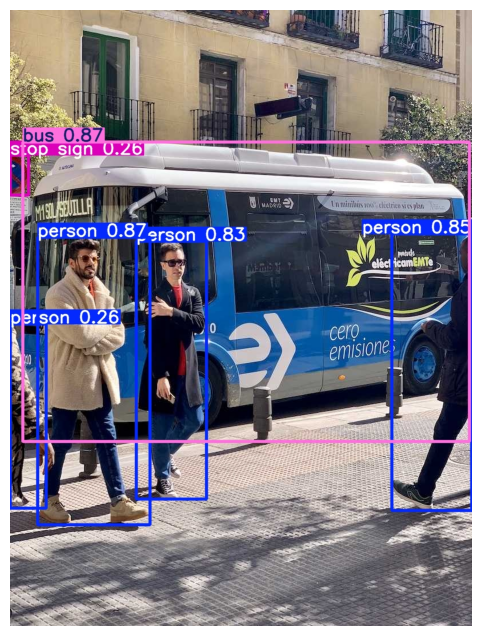

In [11]:
import requests
import os
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

# 1. Baixar imagem de exemplo
url = "https://ultralytics.com/images/bus.jpg"
img_path = "bus.jpg"

if not os.path.exists(img_path):
    print("➡️ Baixando imagem...")
    r = requests.get(url, stream=True)
    with open(img_path, "wb") as f:
        f.write(r.content)

# 2. Carregar modelo YOLO
# Se quiser usar o modelo treinado, troque "yolov8n.pt" por:
# "runs/train/train_coco128_yolov8n/weights/best.pt"
model = YOLO("yolov8n.pt")

# 3. Fazer predição
results = model.predict(source=img_path, conf=0.25, save=True)

# 4. Abrir imagem anotada salva
predicted_img_path = os.path.join(results[0].save_dir, os.path.basename(img_path))
print("✅ Imagem anotada salva em:", predicted_img_path)

# Usar OpenCV para carregar e Matplotlib para exibir
img = cv2.imread(predicted_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()
